In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from utils.narxwithga import NARXModel  # Assuming this will be updated too
import random
from utils.ga import GeneticAlgorithm
import joblib

# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Load and clean data
df = pd.read_csv('data/train_data.csv')
df = df.dropna().reset_index(drop=True)

# Set delays
input_delay = 4
output_delay = 4

columns = ['0.30','0.50','0.75','0.90','0.95','f']

def extract_states(row):
    """
    Given a DataFrame row, returns a (T,6) array of states:
    [t0, t1, t2, t3, x, y] for each percentage in col_perc order.
    """
    states = []
    for p in columns:
        t0 = row[f't0{p}']
        t1 = row[f't1{p}']
        t2 = row[f't2{p}']
        t3 = row[f't3{p}']
        x  = row[f'x{p}']
        y  = row[f'y{p}']
        states.append([t0, t1, t2, t3, x, y])
    return np.array(states)

def prepare_narx_data(df, n_y, n_u=None):
    """
    Builds NARX dataset from multi-step trajectory rows.
    Returns X of shape (N_samples, 4 + 2*n_y + 4*n_u) and Y of shape (N_samples, 2).
    """
    if n_u is None:
        n_u = n_y  # default: same number of delayed inputs and outputs
    
    X_list, Y_list = [], []
    for _, row in df.iterrows():
        states = extract_states(row)    # (T,6)
        angles = states[:, :4]          # (T,4)
        coords = states[:, 4:6]         # (T,2)
        for t in range(max(n_y, n_u), len(states)):
            delayed_coords = coords[t - n_y:t].flatten()  # (2 * n_y,)
            delayed_angles = angles[t - n_u:t].flatten()  # (4 * n_u,)
            x_t = np.concatenate([angles[t], delayed_coords, delayed_angles])
            y_t = coords[t]
            X_list.append(x_t)
            Y_list.append(y_t)
    return np.array(X_list), np.array(Y_list)

# Prepare raw input and output
X_raw = df[['t0', 't1', 't2', 't3']].values 
Y_raw = df[['x', 'y']].values  

# Build NARX-style delayed inputs
X_new = []
Y_new = []

for t in range(max(input_delay, output_delay), len(X_raw)):
    # Stack past input_delay steps in reverse order (t-1, t-2, ..., t-input_delay)
    delayed_inputs = np.concatenate([X_raw[t - i - 1] for i in range(input_delay)])
    delayed_outputs = np.concatenate([Y_raw[t - i - 1] for i in range(output_delay)])
    
    # No current input to avoid leakage
    combined_input = np.concatenate([delayed_inputs, delayed_outputs])
    
    X_new.append(combined_input)
    Y_new.append(Y_raw[t])

X_new = np.array(X_new)
Y_new = np.array(Y_new)

# Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y_new, test_size=0.25, random_state=42)

# Normalize inputs/outputs
input_scaler = StandardScaler()
X_train_norm = input_scaler.fit_transform(X_train)
X_test_norm = input_scaler.transform(X_test)

output_scaler = StandardScaler()
Y_train_norm = output_scaler.fit_transform(Y_train)
Y_test_norm = output_scaler.transform(Y_test)

np.save('data/X_test_norm.npy', X_test_norm)
np.save('data/Y_test_norm.npy', Y_test_norm)
np.save('data/Y_test.npy', Y_test)
joblib.dump(output_scaler, 'models/output_scaler.pkl')
joblib.dump(input_scaler, 'models/input_scaler.pkl')


# Convert to PyTorch tensors
X_tensor = torch.tensor(X_train_norm, dtype=torch.float32)
Y_tensor = torch.tensor(Y_train_norm, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_norm, dtype=torch.float32)

# Determine input dimension
input_dim = (input_delay * X_raw.shape[1]) + (output_delay * Y_raw.shape[1])


c:\Users\Jessy\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [ ]:
# Run Genetic Algorithm
ga = GeneticAlgorithm(
    population_size=20,
    mutation_rate=0.4,
    crossover_rate=0.5,
    input_dim=input_dim,
    X_tensor=X_tensor,
    Y_tensor=Y_tensor,
    tournament_size=5
)

best_model = ga.run(generations=1000)
torch.save(best_model.state_dict(), 'models/best_ga_model.pth')
print("Model saved to 'best_ga_model.pth'")

with torch.no_grad():
    predictions = best_model(X_test_tensor).numpy()
    predictions_original = output_scaler.inverse_transform(predictions)
    Y_test_original = output_scaler.inverse_transform(Y_test_norm)

    preds_train_norm = best_model(X_tensor).numpy()
    preds_train = output_scaler.inverse_transform(preds_train_norm)
    Y_train_true = output_scaler.inverse_transform(Y_tensor.numpy())

Generation 1, Best Fitness (MSE): 1.46562
Generation 2, Best Fitness (MSE): 0.98502
Generation 3, Best Fitness (MSE): 0.98502
Generation 4, Best Fitness (MSE): 0.91080
Generation 5, Best Fitness (MSE): 0.77391
Generation 6, Best Fitness (MSE): 0.64829
Generation 7, Best Fitness (MSE): 0.56974
Generation 8, Best Fitness (MSE): 0.56974
Generation 9, Best Fitness (MSE): 0.54802
Generation 10, Best Fitness (MSE): 0.53997
Generation 11, Best Fitness (MSE): 0.48632
Generation 12, Best Fitness (MSE): 0.48632
Generation 13, Best Fitness (MSE): 0.48082
Generation 14, Best Fitness (MSE): 0.39911
Generation 15, Best Fitness (MSE): 0.39911
Generation 16, Best Fitness (MSE): 0.38529
Generation 17, Best Fitness (MSE): 0.38529
Generation 18, Best Fitness (MSE): 0.38529
Generation 19, Best Fitness (MSE): 0.38529
Generation 20, Best Fitness (MSE): 0.38529
Generation 21, Best Fitness (MSE): 0.38529
Generation 22, Best Fitness (MSE): 0.37507
Generation 23, Best Fitness (MSE): 0.31632
Generation 24, Best 

In [26]:
print("\nTrain set performance:")
print(f"MSE : {mean_squared_error(Y_train_true, preds_train):.5f}")
print(f"RMSE: {np.sqrt(mean_squared_error(Y_train_true, preds_train)):.5f}")
print(f"MAE : {mean_absolute_error(Y_train_true, preds_train):.5f}")
print(f"R^2 : {r2_score(Y_train_true, preds_train):.5f}")

print("\nEvaluation Metrics on Test Data:")
print(f"MSE : {mean_squared_error(Y_test_original, predictions_original):.5f}")
print(f"RMSE: {np.sqrt(mean_squared_error(Y_test_original, predictions_original)):.5f}")
print(f"MAE : {mean_absolute_error(Y_test_original, predictions_original):.5f}")
print(f"R^2 : {r2_score(Y_test_original, predictions_original):.5f}")


Train set performance:
MSE : 0.00046
RMSE: 0.02148
MAE : 0.01499
R^2 : 0.92819

Evaluation Metrics on Test Data:
MSE : 0.00036
RMSE: 0.01885
MAE : 0.01423
R^2 : 0.93632


In [16]:
import torch
import numpy as np
import random
import joblib
import pandas as pd
from utils.narxwithga import NARXModel

# Load saved assets
X_test_norm = np.load("data/X_test_norm.npy")
Y_test_norm = np.load("data/Y_test_norm.npy")   # normalized
Y_test = np.load("data/Y_test.npy")             # unnormalized
output_scaler = joblib.load("models/output_scaler.pkl")
input_scaler = joblib.load("models/input_scaler.pkl")
input_dim = X_test_norm.shape[1]

# Load model
model = NARXModel(input_dim=input_dim, output_dim=2)
model.load_state_dict(torch.load("models/best_ga_model.pth"))
model.eval()

# Choose a random test index
rand_test_index = random.randint(0, len(X_test_norm) - 1)

# Prepare input tensor
input_tensor = torch.tensor(X_test_norm[rand_test_index:rand_test_index+1], dtype=torch.float32)
true_output = Y_test[rand_test_index]  # already unnormalized

# Predict
with torch.no_grad():
    pred_scaled = model(input_tensor).numpy()
    pred_original = output_scaler.inverse_transform(pred_scaled)

# Print prediction vs ground truth
print("\n--- Random Test Sample Evaluation ---")
print(f"Random Test Index: {rand_test_index}")
print(f"Predicted (x, y): {pred_original[0]}")
print(f"Ground Truth (x, y): {true_output}")



--- Random Test Sample Evaluation ---
Random Test Index: 70
Predicted (x, y): [ 0.1727773 -0.1167324]
Ground Truth (x, y): [ 0.18 -0.11]


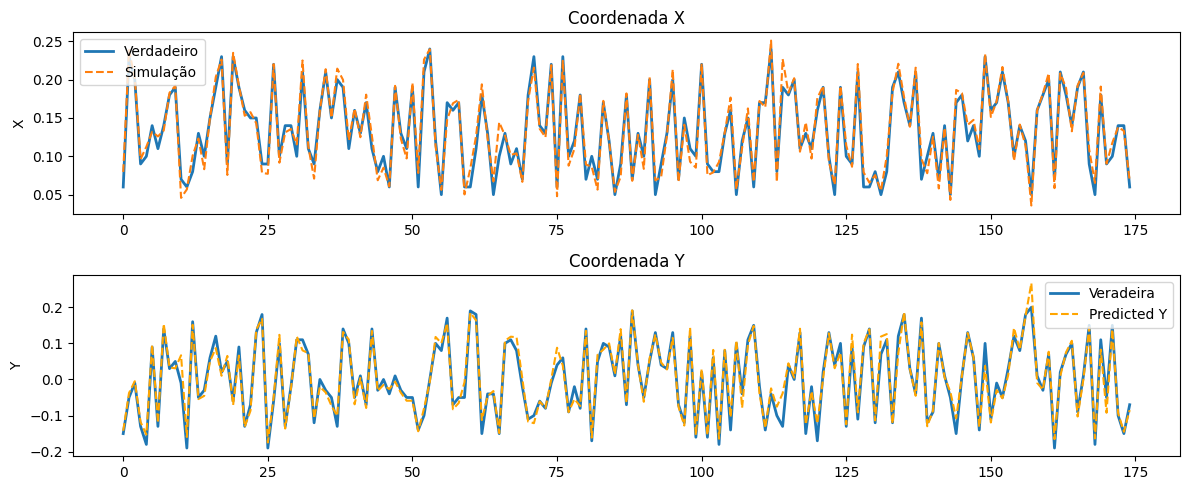

In [23]:
X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32)
with torch.no_grad():
    all_preds_scaled = model(X_test_tensor).numpy()
    all_preds = output_scaler.inverse_transform(all_preds_scaled)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(2, 1, 1)
plt.plot(Y_test[:, 0], label='Verdadeiro', linewidth=2)
plt.plot(all_preds[:, 0], label='Simulação', linestyle='--')
plt.title('Coordenada X')
plt.ylabel('X')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(Y_test[:, 1], label='Veradeira', linewidth=2)
plt.plot(all_preds[:, 1], label='Predicted Y', linestyle='--', color='orange')
plt.title('Coordenada Y')
plt.ylabel('Y')
plt.legend()

plt.tight_layout()
plt.show()


In [36]:
import torch
import numpy as np
import joblib
from utils.narxwithga import NARXModel

# === Load scalers and model ===
input_scaler = joblib.load("models/input_scaler.pkl")
output_scaler = joblib.load("models/output_scaler.pkl")
X_test_norm = np.load("data/X_test_norm.npy")
input_dim = X_test_norm.shape[1]

model = NARXModel(input_dim=input_dim, output_dim=2)
model.load_state_dict(torch.load("models/best_ga_model.pth"))
model.eval()

# === Config ===
input_delay = 4
output_delay = 4
angle_dim = 4
coord_dim = 2
print("==== NARX Prediction from User Input ====")
print(f"Assuming input_delay={input_delay}, output_delay={output_delay}")
print("Initial histories filled with zeros.\n")

df = pd.read_csv("data/narx_train_dataset.csv").dropna()

columns = ['0.30','0.50','0.75','0.90','0.95','f']

def extract_states(row):
    """
    Given a DataFrame row, returns a (T,6) array of states:
    [t0, t1, t2, t3, x, y] for each percentage in col_perc order.
    """
    states = []
    for p in columns:
        t0 = row[f't0{p}']
        t1 = row[f't1{p}']
        t2 = row[f't2{p}']
        t3 = row[f't3{p}']
        x  = row[f'x{p}']
        y  = row[f'y{p}']
        states.append([t0, t1, t2, t3, x, y])
    return np.array(states)


angle_columns = ['t0', 't1', 't2', 't3']
coord_columns = ['x', 'y']

states = extract_states(df.iloc[0])  # shape (6, 6)

# Separate into angles and coords
angles = states[:, :4]   # shape (6, 4)
coords = states[:, 4:]   # shape (6, 2)

# Use first `input_delay` and `output_delay` for delayed histories
delayed_inputs = angles[:input_delay]     # shape: (4, 4)
delayed_outputs = coords[:output_delay]   # shape: (4, 2)

while True:
    try:
        user_input = input("Enter 4 joint angles separated by commas (or 'q' to quit): ")
        if user_input.lower() == 'q':
            break

        angles = np.array([float(val.strip()) for val in user_input.split(",")])
        if len(angles) != angle_dim:
            raise ValueError("Please enter exactly 4 joint angles.")

        # Shift histories
        delayed_inputs = np.roll(delayed_inputs, shift=-1, axis=0)
        delayed_outputs = np.roll(delayed_outputs, shift=-1, axis=0)

        # Update current input (most recent)
        delayed_inputs[-1] = angles

        # Construct full NARX-style input: [current, output history, input history]
        # Flatten: [current_input, delayed_outputs, delayed_inputs]
        current_input = angles
        flat_outputs = delayed_outputs.flatten()
        flat_inputs = delayed_inputs.flatten()
        narx_input = np.concatenate([current_input, flat_outputs, flat_inputs])

        # Pad if necessary (for first few steps)
        if narx_input.shape[0] < input_dim:
            padding = np.zeros(input_dim - narx_input.shape[0])
            narx_input = np.concatenate([narx_input, padding])

        # Scale and predict
        narx_input_scaled = input_scaler.transform([narx_input])
        input_tensor = torch.tensor(narx_input_scaled, dtype=torch.float32)

        with torch.no_grad():
            pred_scaled = model(input_tensor).numpy()
            pred_original = output_scaler.inverse_transform(pred_scaled)

        # Save output to history
        delayed_outputs[-1] = pred_original[0]

        print(f"✅ Predicted (x, y): {pred_original[0]}\n")
        print(f"four coordinates of the last 4 steps: {delayed_outputs.flatten()}")

    except Exception as e:
        print(f"⚠️ Error: {e}\n")


==== NARX Prediction from User Input ====
Assuming input_delay=4, output_delay=4
Initial histories filled with zeros.

✅ Predicted (x, y): [ 1.331737 13.947748]

four coordinates of the last 4 steps: [ 0.0975     -0.095       0.12875    -0.1425      0.1475     -0.171
  1.33173704 13.94774818]
